In [1]:
import pandas as pd
df = pd.read_csv('smoking.csv')
df = df[:10000]

In [2]:
#CON BILANCIAMENTO O SENZA NON CAMBIANO LE PERFORMANCE

# from sklearn.utils import resample
# 
# #Trova la classe target più rappresentata
# target_max = df['smoking'].value_counts().idxmax()
# 
# #Suddividi il dataset in due parti in base alla classe target
# df_magg = df[df['smoking'] == target_max]
# df_min = df[df['smoking'] != target_max]
# 
# #Riduci il numero di campioni nella classe maggioritaria al numero di campioni nella classe minoritaria
# df_magg_downsampled = resample( df_magg,
#                                 replace=False,  # campioni presi senza sostituzione
#                                 n_samples=len(df_min),  # numero di campioni uguale alla classe minoritaria
#                                 random_state=42)  # per riproducibilità
# 
# #Unisci i due sottoinsiemi bilanciati
# df_filtered = pd.concat([df_magg_downsampled, df_min])
# 
# print("\nCounts nel dataset partizionato:\n", df_filtered['smoking'].value_counts())

In [3]:
df = df.drop(['ID', 'height(cm)', 'oral'], axis=1)
df['tartar'] = df['tartar'].apply(lambda x: 1 if x == 'Y' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('smoking', axis=1)
y = df['smoking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Fai le predizioni sul set di test
y_true = np.ones(len(y_test))
y_pred = np.ones(len(y_test))

# Calcola la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Stampa la matrice di confusione
print("Matrice di Confusione:")
print(cm)

Matrice di Confusione:
[[   0 1941]
 [   0 1059]]


In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model, filled=True, ax=ax)
plt.plot()

[]

In [7]:
# predizione del nuovo modello
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())

Confusion matrix:
 [[1442  499]
 [ 429  630]]

Accuracy: 0.6906666666666667


In [8]:
# andiamo a lavorare sul parametro di complessità, che stima il vantaggio di aggiungere/togliere degli split
# in funzione degli errori di classificazione
# più il modello è complesso e più viene penalizzato
path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

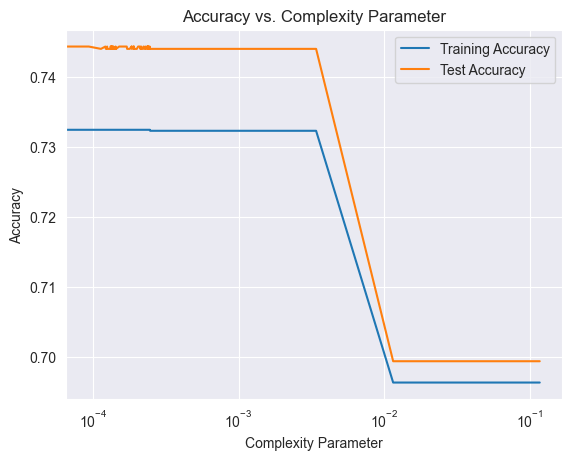

In [9]:
# valori di complessità candidati ad essere tagliati dal modello
# complexity_values = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [10]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11735577440370953


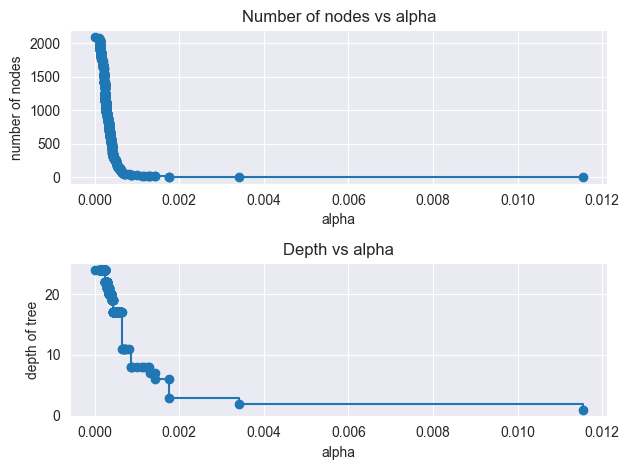

In [11]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [12]:
# Codice duplicato - sopra c'è già questo grafico

# complexity_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
#
# train_accuracy = []
# test_accuracy = []
# for complexity in complexity_values:
#     clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
#     clf.fit(X_train, y_train)
#     train_accuracy.append(clf.score(X_train, y_train))
#     test_accuracy.append(clf.score(X_test, y_test))
#
#
# plt.plot(complexity_values, train_accuracy, label='Training Accuracy')
# plt.plot(complexity_values, test_accuracy, label='Test Accuracy')
# plt.xlabel('Complexity Parameter')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs. Complexity Parameter')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [13]:
# Potiamo albero con alpha=0.001
clf_pruned = DecisionTreeClassifier(max_depth=3, ccp_alpha=0.001)
clf_pruned.fit(X_train, y_train)

accuracy_pruned = clf_pruned.score(X_test, y_test)
print(accuracy_pruned)

0.744


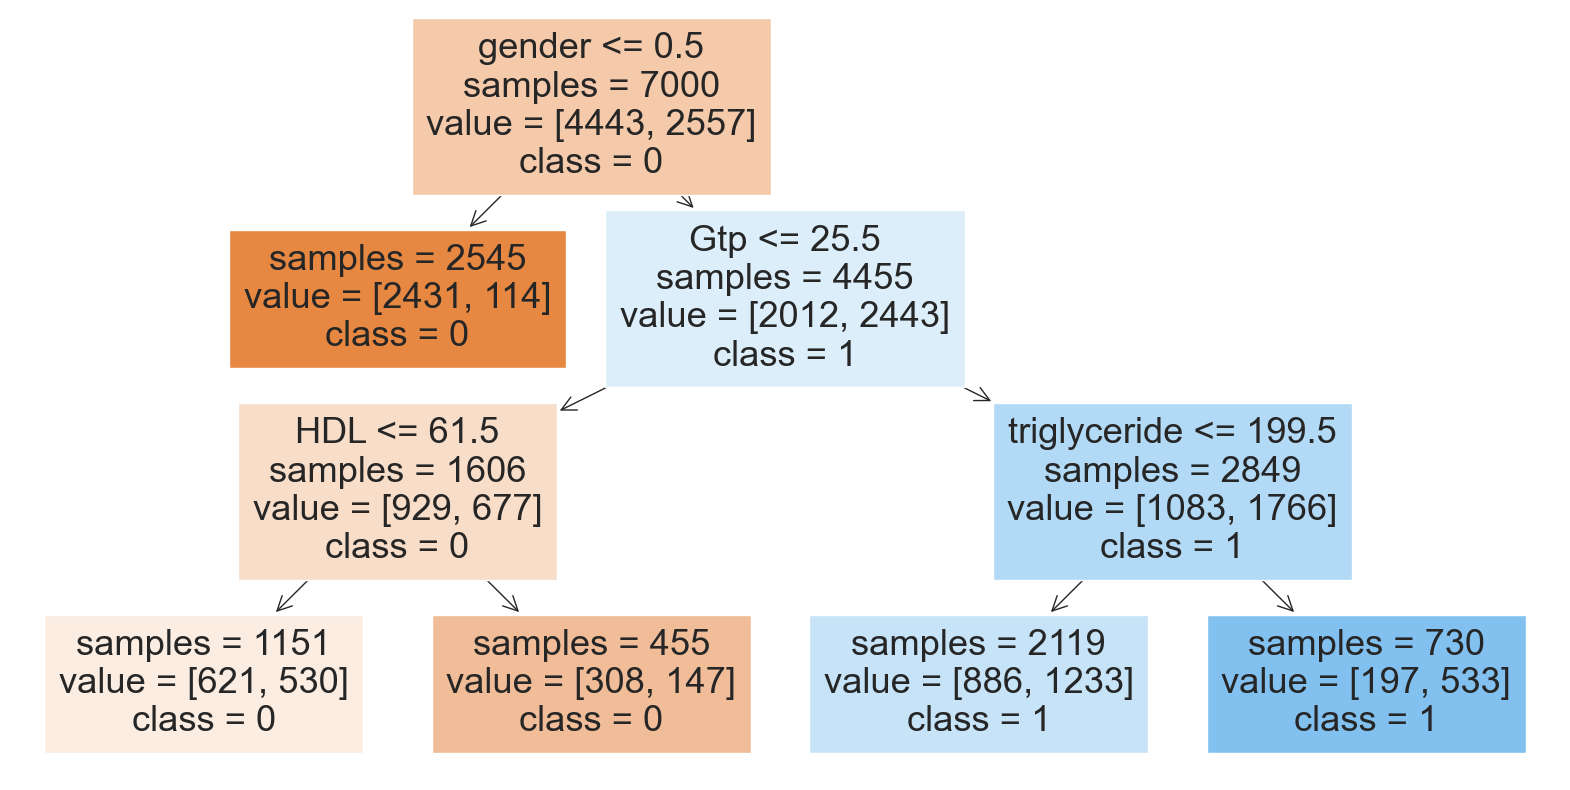

Confusion matrix:
 [[1492  449]
 [ 319  740]]

Accuracy: 0.744


In [14]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(clf_pruned,
          feature_names=X_train.columns,
          class_names=[str(x) for x in clf_pruned.classes_],
          filled=True,
          ax=ax,
          impurity=False)

plt.show()
from sklearn.metrics import confusion_matrix

y_pred = clf_pruned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())